In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score, confusion_matrix, balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import copy

In [2]:
from ResNet_3D import generate_model
from utils.ADNI_Dataset import ADNI_Dataset
from utils.transfer_to_df import transfer_to_df
from prune_model.utils.evaluation import get_test_objective_

In [3]:
#protected attributes in the study are gender and age
attr="gender" 

# Set the below variables to 1 to activeate the methods proposed in our study
performance_influence = 1
continue_pruning = 1
prune_with_tnr_info = 1

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"

In [6]:
def generate_training_set(fold):
    train_set_link = pd.read_csv('data_MRI/train_p0_fold_'+str(fold)+'.csv')
    val_set_link = pd.read_csv('data_MRI/val_p0_fold_'+str(fold)+'.csv')
    test_set_link = pd.read_csv('data_MRI/test_p0_fold_'+str(fold)+'.csv')
    train_set = transfer_to_df(train_set_link)
    val_set = transfer_to_df(val_set_link)
    test_set = transfer_to_df(test_set_link)
    return train_set, val_set, test_set
train_set, val_set, test_set = generate_training_set(1) 

In [7]:
bathcSize=16
Train_Data_set=ADNI_Dataset(dataframe=train_set, ATTR=attr, transform=True, phase="train")
Val_Data_set=ADNI_Dataset(dataframe=val_set, ATTR=attr, transform=False, phase="val")
Test_Data_set=ADNI_Dataset(dataframe=test_set, ATTR=attr, transform=False, phase="test")
train_dataloader = DataLoader(Train_Data_set, batch_size=bathcSize, shuffle=True)
val_dataloader = DataLoader(Val_Data_set, batch_size=bathcSize, shuffle=True)
test_dataloader = DataLoader(Test_Data_set, batch_size=bathcSize, shuffle=True)

## Show MRI data

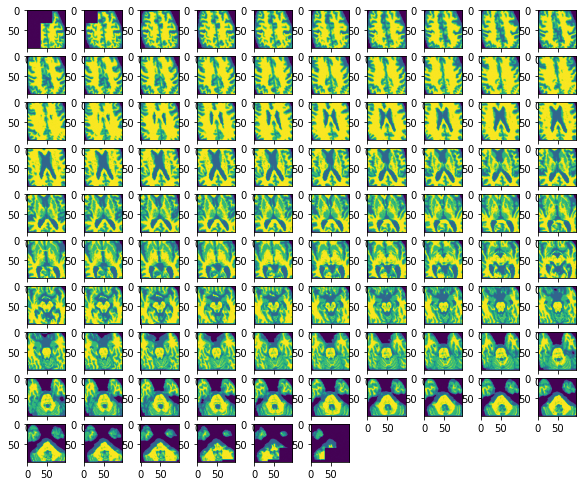

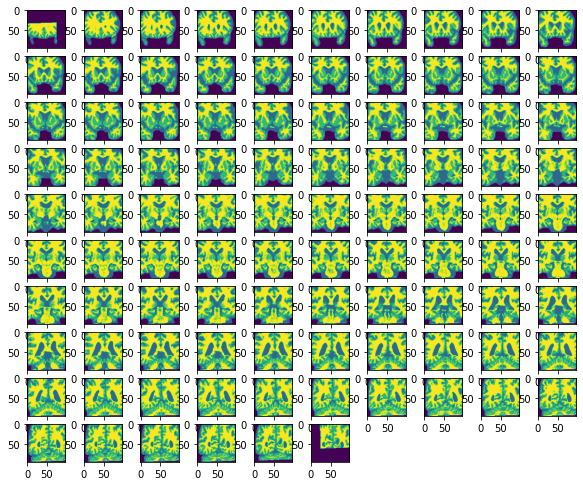

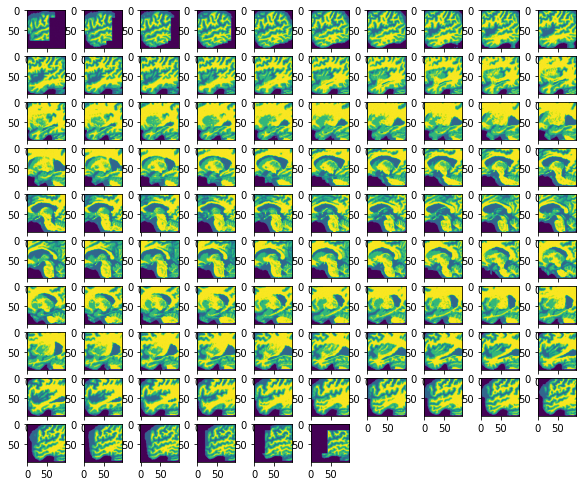

In [8]:
channel=96
step, data = next(enumerate(train_dataloader))
img=data[0][0]     

for i in range(channel):
    plt.subplot(12, 10, i+1)
    plt.imshow(img[0,i,:,:])

    plt.gcf().set_size_inches(10,10)
plt.show()

for i in range(channel):
    plt.subplot(12, 10, i+1)
    plt.imshow(img[0,:,i,:])

    plt.gcf().set_size_inches(10,10)
plt.show()

for i in range(channel):
    plt.subplot(12, 10, i+1)
    plt.imshow(img[0,:,:,i])

    plt.gcf().set_size_inches(10,10)
plt.show()

## Masked model

In [9]:
class ResNet18Masked(nn.Module):
    def __init__(self, base_model, prunable_layers, start_idx, end_idx):
        super().__init__()
        self.all_layers = [base_model.conv1, base_model.bn1, base_model.relu,
                           base_model.maxpool, base_model.layer1, base_model.layer2,
                           base_model.layer3, base_model.layer4, base_model.avgpool,
                           base_model.classifier]
               
        
        base_model.relu.inplace = False
        layers_tmp = get_children(base_model)
        for l in layers_tmp:
            if isinstance(l, nn.ReLU):
                l.inplace = False

        self.prunable_layers = prunable_layers
        self.start_idx = start_idx
        self.end_idx = end_idx

    def forward(self, t, pruned=None):
        cnt = 0
        cnt_ = 0
        

        for (i, l) in enumerate(self.all_layers):
            t = l(t).clone()

            # prune neurons
            if l in self.prunable_layers:
#                 print(l)
                if pruned is not None:

                    pruned_structs = pruned[np.logical_and(self.start_idx[cnt] <= pruned,
                                                           pruned < self.end_idx[cnt])] - cnt_

                    i_hat = (pruned_structs / (t.shape[2] * t.shape[3] * t.shape[4])).astype(int)
                    j_hat = ((pruned_structs - t.shape[2] * t.shape[3] * t.shape[4] * i_hat) / (t.shape[3] * t.shape[4])).astype(int)
                    k_hat = ((pruned_structs - t.shape[2] * t.shape[3] * t.shape[4] * i_hat - j_hat * t.shape[3] * t.shape[4]) / t.shape[4]).astype(int)
                    l_hat = (pruned_structs - t.shape[2] * t.shape[3] * t.shape[4] * i_hat - j_hat * t.shape[3] * t.shape[4] - k_hat * t.shape[4]).astype(int)

                    t[:, i_hat, j_hat, k_hat, l_hat] = 0

                    cnt_ += t.shape[1] * t.shape[2] * t.shape[3] * t.shape[4]
                    cnt += 1

            if i == len(self.all_layers) - 2:
                t = torch.flatten(t, 1)
        return t

def get_children(model: torch.nn.Module):

    children = list(model.children())
    flatt_children = []
    if children == []:
        return model
    else:
        for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [10]:
def install_hooks(layers):
    activation = {}
    handles = {}

    def get_activation(name):
        def hook(model, input, output):
            output.retain_grad()
            activation[name] = output

        return hook

    for (i, l) in enumerate(layers):
#         print(l)
        handles['l' + str(i)] = l.register_forward_hook(get_activation('l' + str(i)))

    return activation, handles

def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            remove_all_forward_hooks(child)
    
def plot_matrix(target, y_pred):
    cf_matrix = confusion_matrix(target, y_pred)                               
    per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   
    class_names = ['CN', 'AD']

    return cf_matrix


def eval_saliency_dataloaders(model, layers, data_loader, activation, device, asc, pruned=None):
    """Evaluates the gradient-based bias influence of units given the data loaders"""
    total_n_structs = 0
    n_structs = []
    start_idx = []
    end_idx = []
    loss_function = nn.CrossEntropyLoss()

    model.eval()

    __ = model(torch.zeros((bathcSize, 1, 96, 96, 96)).to(device).to(torch.float))

    for i_l, l in enumerate(layers):
        start_idx.append(total_n_structs)

        total_n_structs += activation['l' + str(i_l)].shape[1] * activation['l' + str(i_l)].shape[2] * \
                            activation['l' + str(i_l)].shape[3] * activation['l' + str(i_l)].shape[4]
            
        n_structs.append(activation['l' + str(i_l)].shape[1] * activation['l' + str(i_l)].shape[2] * \
                         activation['l' + str(i_l)].shape[3] * activation['l' + str(i_l)].shape[4])
            
        end_idx.append(total_n_structs)
       
    coeffs = np.zeros((total_n_structs,))

    tmp = 0
    print("Eval_saliency...")
    loop = tqdm(enumerate(data_loader), total =len(data_loader))
    for step, data in loop:
        inputs, labels, attrs = data
        inputs, labels, attrs = inputs.to(device).float(), labels.to(device), attrs.to(device)
        
        model.zero_grad()
        X = inputs
        y = labels.to(torch.float)
        p = attrs
        
        bias_measure = None
        loss = None
    
        if pruned is None:
            outputs = model(X)
        else:
            outputs = model(X, pruned=np.array(pruned))
            
        outputs = torch.sigmoid(outputs)
        preds = outputs[:,1]
    
        
        tp_0 = torch.mean(preds[torch.logical_and(p == 0, y == 1)])
        tp_1 = torch.mean(preds[torch.logical_and(p == 1, y == 1)]) 
        tn_0 = 1-torch.mean(preds[torch.logical_and(p == 0, y == 0)])
        tn_1 = 1-torch.mean(preds[torch.logical_and(p == 1, y == 0)]) 
        
        balance_acc_0 = (tp_0+tn_0)/2
        balance_acc_1 = (tp_1+tn_1)/2
    
        if prune_with_tnr_info==1:
            bias_measure = balance_acc_0-balance_acc_1
        else:
            bias_measure = tp_0 - tp_1            

        tmp += 1
        if not torch.isnan(bias_measure):
            # Backpropagate the bias
            bias_measure.backward(retain_graph=True)
            for (i, l) in enumerate(layers):
                layer_key = 'l' + str(i)
                coeffs[start_idx[i]:end_idx[i]] += torch.mean(activation[layer_key].grad, 0).cpu().numpy().flatten()
                
        
        if performance_influence:
            if pruned is None:
                outputs = model(X)
            else:
                outputs = model(X, pruned=np.array(pruned))

            loss = loss_function(outputs, labels)

            if not torch.isnan(loss):
                # Backpropagate the loss
                loss.backward(retain_graph=True)
                for (i, l) in enumerate(layers):
                    layer_key = 'l' + str(i)
                    if asc==1:
                        coeffs[start_idx[i]:end_idx[i]] -= torch.mean(activation[layer_key].grad, 0).cpu().numpy().flatten()
                    else:
                        coeffs[start_idx[i]:end_idx[i]] += torch.mean(activation[layer_key].grad, 0).cpu().numpy().flatten()

    return coeffs, n_structs, start_idx, end_idx


In [11]:
def plot_pruning_results(iteration, bias_metric, pred_performance, fold, phase):
    fig = plt.figure()
    
    plt.plot(iteration, pred_performance, label='Accuracy', color='slategray')
    plt.plot(iteration, bias_metric, label='Bias', color='coral')
    
    plt.xlabel('Number of Iterations')
    plt.legend()
    plt.savefig(fname="prune_model/picture/pruning_result.png", bbox_inches="tight")

    plt.show()


In [12]:
def plot_matrix(target, y_pred):
    cf_matrix = confusion_matrix(target, y_pred)                               
    per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   
    class_names = ['CN', 'AD']

    return cf_matrix
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
def model_evaluate_with_target_attr(target_attr, model, dataloader, to_prune):
    "calaulate the model performace of different subgroups (male/female, young/old)"
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    target=[]
    prob=[]
    y_pred=[]
    n=0
    loss_function = nn.CrossEntropyLoss()
    print("TARGET:", target_attr)
    with torch.no_grad():
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for step,data in loop:
            inputs, labels, p_attr = data
            if(p_attr!=target_attr):
                continue
            n+=1
            inputs, labels, p_attr = inputs.to(device).float(), labels.to(device), p_attr.to(device)

            outputs = model(inputs, to_prune)
            outputs = torch.sigmoid(outputs)


            loss = loss_function(outputs,labels) 
            test_loss += loss.item()

            target.extend(np.array(labels.cpu()))
            prob.extend(outputs[:, 1].detach().cpu().numpy())



            pred=torch.max(outputs, dim=1)[1]
            y_pred.extend(np.array(pred.cpu()))


            num_correct = (pred == labels).sum()
            test_accuracy += float(num_correct)

            loop.set_description(f'Test epoch')
            loop.set_postfix(step=n, loss = test_loss/n, acc = test_accuracy/n)

    fpr, tpr, threshold = roc_curve(target, prob)
    auc_curve = auc(fpr, tpr)
    cf_matrix = plot_matrix(target, y_pred)

    _tp = cf_matrix[1, 1]
    _fn = cf_matrix[1, 0]
    _fp = cf_matrix[0, 1]
    _tn = cf_matrix[0, 0]
    _tpr = _tp / (_tp + _fn)
    _fpr = _fp / (_tn + _fp)
    _tnr = _tn / (_tn + _fp)
    _fnr = _fn / (_fn + _tp)
    
    result = {}
    result['ACC'] = accuracy_score(target, y_pred)
    result['AUC'] = roc_auc_score(target, prob)
    result['TPR'] = _tpr
    result['PRECISION'] = precision_score(target, y_pred)
    result['ERROR'] = (_fn+_fp)/(_tp+_fn+_fp+_tn)
    result['FPR'] = _fpr
    result['FNR'] = _fnr
    result['TNR'] = _tnr
    result['EP'] = abs(_fnr-_fpr)
    
    print("TNR: "+str(result['TNR']))
    print("TPR: "+str(result['TPR']))
    
    
    return result

In [13]:
def evaluate_step(evaluate_dataloader, model, pruned):  
    y_pred = []
    y_valid = []
    p_valid = []

    cnt = 0
    for X_, y_, p_ in evaluate_dataloader:
        X_ = X_.to(device).to(torch.float)
        y_ = y_.to(device).to(torch.float)
        p_ = p_.to(device)

        with torch.enable_grad():
            if pruned is None:
                outputs = model(X_)  
            else:
                outputs = model(X_, pruned=np.array(pruned))
            outputs = torch.sigmoid(outputs)

        y_pred.extend(np.array(torch.max(outputs, dim=1)[1].cpu()))

        y_valid.extend(y_.cpu().numpy())
        p_valid.extend(p_.cpu().numpy())
        cnt += 1

    best_thresh = 0.5
    y_pred = np.array(y_pred)
    y_valid = np.array(y_valid)
    p_valid = np.array(p_valid)
    obj_dict = get_test_objective_(y_pred=y_pred , y_test=y_valid, p_test=p_valid, attr=attr, prune_with_tnr_info=prune_with_tnr_info)
    return obj_dict

## Implement five-fold cross-validation

In [ ]:
for ff in range(5):
    fold=ff+1
    
    print("==============fold "+str(fold)+"==============")
    
    bathcSize=16
    train_set, val_set, test_set = generate_training_set(fold) 
    Train_Data_set=ADNI_Dataset(dataframe=train_set, ATTR=attr, transform=True, phase="train")
    Val_Data_set=ADNI_Dataset(dataframe=val_set, ATTR=attr, transform=False, phase="val")
    Test_Data_set=ADNI_Dataset(dataframe=test_set, ATTR=attr, transform=False, phase="test")
    val_dataloader = DataLoader(Val_Data_set, batch_size=bathcSize, shuffle=True)
    test_dataloader = DataLoader(Test_Data_set, batch_size=bathcSize, shuffle=True)
    
#     import the pretrain baseline model
    path_name='baseline_model/baseline_model_'+str(fold)+'.pth'
    model=torch.load(path_name)

#     set pruning parameters
    pruning_batchsize = bathcSize
    pruning_stop_early = True
    pruning_max_steps = 25
    ori_performance = 0
    pruning_obj_lb = 0.75
    dataset_size_evaluate = len(Val_Data_set)
    evaluate_dataloader = val_dataloader
    pruning_dataloader = val_dataloader

    prunable_layers = [model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool]
    activation, handles = install_hooks(layers=prunable_layers)
    
    step_count = []
    bias_metric = []
    pred_performance = []
    test_bias_metric = []
    test_pred_performance = []
    
    pruned = []

    best_bias = 1
    to_prune_best = None
    asc=0
    
    #evaluate the origin model
    model.eval()

    with torch.no_grad():

        obj_dict = evaluate_step(evaluate_dataloader, model, pruned=None)
        test_obj_dict = evaluate_step(test_dataloader, model, pruned=None)
    
        #show the evaluation result
        print("evaluate the origin model")
        print(obj_dict)
        bias_metric.append(obj_dict['bias'])
        pred_performance.append(obj_dict['performance'])
        test_bias_metric.append(test_obj_dict['bias'])
        test_pred_performance.append(test_obj_dict['performance'])
        
        ori_performance = obj_dict['performance']
#         set the stopping threshold
        pruning_obj_lb = ori_performance*0.9

        # The order that the neurons are pruned
        asc = obj_dict['bias'] < 0        
        step_count.append(0)
    
    model.zero_grad()

    # Compute gradient-based bias influence of the units
    coeffs, n_structs, start_idx, end_idx = eval_saliency_dataloaders(
            model=model, layers=prunable_layers, data_loader=pruning_dataloader, activation=activation, device=device,
            asc=asc, pruned=None)

    # Sort units according to their influence
    if asc:
        struct_inds = np.argsort(coeffs)
    else:
        struct_inds = np.argsort(-coeffs)
    
    # Set the number of neurons to prune in each pruning step
    pruning_stepsize = int(len(struct_inds)*1e-5)
    
    # Construct a masked model 
    model_mask = ResNet18Masked(model, prunable_layers, start_idx, end_idx)
    model_mask.eval()

    with torch.no_grad():

        cnt = 0
        step_num = 0
        for j in range(0, len(struct_inds), pruning_stepsize):
            print("Pruning step: {}".format(step_num+1))
            # Reassess influence scores
            if j > 0:
                with torch.enable_grad():
                    coeffs, n_structs, start_idx, end_idx = eval_saliency_dataloaders(
                        model=model_mask, layers=prunable_layers, data_loader=pruning_dataloader, activation=activation, device=device,
                        asc=asc, pruned=pruned)

                if asc:
                    struct_inds = np.argsort(coeffs)
                else:
                    struct_inds = np.argsort(-coeffs)

            to_prune = struct_inds[cnt:(cnt + pruning_stepsize)]
            for _ in to_prune:
                pruned.append(_)

            # Evaluate the pruned model on validation data
            obj_dict = evaluate_step(evaluate_dataloader, model_mask, pruned)
            test_obj_dict = evaluate_step(test_dataloader, model_mask, pruned)
                
            if continue_pruning==1:
                asc = obj_dict['bias'] < 0
            print(obj_dict)
            
            # Stop pruning if the predictive performance drops below a certain level
            if pruning_stop_early and obj_dict['performance'] <= pruning_obj_lb:
                print("Early stopping, performance <= "+str(pruning_obj_lb))
                break

            # Save the least biased model that satisfies the specified constraint on the performance
            if continue_pruning==0 and np.abs(obj_dict['bias']) <= best_bias:
                best_bias = np.abs(obj_dict['bias'])
                to_prune_best = copy.deepcopy(pruned)
            else:
                best_bias = np.abs(obj_dict['bias'])
                to_prune_best = copy.deepcopy(pruned) 

            # Stop pruning if a maximum number of pruning steps has been reached
            if pruning_stop_early and step_num >= pruning_max_steps:
                print("Early stopping, step_num >= pruning_max_steps")
                break

            
            if continue_pruning==0:
                if ((obj_dict['bias']>0 and asc==1) or (obj_dict['bias']<0 and asc==0)):
                    print("Early stopping, bias reach " + str(best_bias))
                    break
            
            step_count.append(step_num+1)
            bias_metric.append(obj_dict['bias'])
            pred_performance.append(obj_dict['performance'])
            test_bias_metric.append(test_obj_dict['bias'])
            test_pred_performance.append(test_obj_dict['performance'])
            
            step_num += 1
            
        plot_pruning_results(iteration=step_count, bias_metric=bias_metric, pred_performance=pred_performance, fold=fold, phase="val")
        plot_pruning_results(iteration=step_count, bias_metric=test_bias_metric, pred_performance=test_pred_performance, fold=fold, phase="test")

#         if nothing is pruned, set a dummy neuron
        if to_prune_best==None:
            to_prune = np.array([321658])
        else:
            to_prune = np.array(to_prune_best)
            
        np.save("prune_model/parameters/to_prune_"+str(fold)+".npy", to_prune)
        model_mask.eval()


        remove_all_forward_hooks(model)
        for k_h, h in handles.items():
            handles[k_h].remove()

    Val_Data_set=ADNI_Dataset(dataframe=val_set, ATTR=attr, transform=False, phase="val")
    Test_Data_set=ADNI_Dataset(dataframe=test_set, ATTR=attr, transform=False, phase="test")
    val_dataloader = DataLoader(Val_Data_set, batch_size=1, shuffle=True)
    test_dataloader = DataLoader(Test_Data_set, batch_size=1, shuffle=True)
    
    
    
#     compute the gap between each subgroup
    val_result_0 = model_evaluate_with_target_attr(0, model_mask, val_dataloader, to_prune)
    val_result_1 = model_evaluate_with_target_attr(1, model_mask, val_dataloader, to_prune)
    test_result_0 = model_evaluate_with_target_attr(0, model_mask, test_dataloader, to_prune)
    test_result_1 = model_evaluate_with_target_attr(1, model_mask, test_dataloader, to_prune)

    metrics = ['ACC', 'AUC', 'TPR', 'PRECISION', 'ERROR', 'FPR', 'FNR', 'EP', 'TNR']
    val_gap = {}
    test_gap = {}
    for m in metrics:
        val_gap[m] = np.ptp(np.vstack((val_result_0[m], val_result_1[m])).T, axis=1)
        test_gap[m] = np.ptp(np.vstack((test_result_0[m], test_result_1[m])).T, axis=1)

    R = [[], [], [], [], [], [], [], [], []]
    for i in range(len(R)):
        R[i] = [val_result_0[metrics[i]],val_result_1[metrics[i]],val_gap[metrics[i]][0],test_result_0[metrics[i]],test_result_1[metrics[i]],test_gap[metrics[i]][0]]    
    
#     save each five-fold results respectively
    df_csv = pd.DataFrame({'ACC':R[0], 'AUC':R[1], 'TPR':R[2], 'PRECISION':R[3], 'ERROR':R[4], 'FPR':R[5],'FNR':R[6],'EP':R[7], 'TNR':R[8]})
    path_name = 'prune_model/result/'+attr+'_result_'+str(fold)+'.csv'
    df_csv.to_csv(path_name, index=False)